# Customer Churn Prediction Capstone
Built by ATISHA MEHTA 
Date: 24 Dec 2025
Dataset: Telco Customer Churn + Realistic Customer Feedback (Kaggle)
Skills: SQL, Python, EDA, ML/DL, Time-Series, NLP, Power BI".

In [84]:
!pip install pandas


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
import pandas as pd
df = pd.read_csv('telco_churn_with_all_feedback.csv')  # Adjust path
print(df.head())  # First 5 rows
print(df.info())  # Columns, types, nulls
print(df['Churn'].value_counts())  # Churn balance (~26% Yes)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...          No   
4                No     Fiber optic             No  ...          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0          

In [86]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nFirst 3 rows (focus on feedback):\n", df[['customerID', 'tenure', 'Churn', 'CustomerFeedback']].head(3))

Shape: (7043, 23)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'PromptInput', 'CustomerFeedback']

First 3 rows (focus on feedback):
    customerID  tenure Churn                                   CustomerFeedback
0  7590-VHVEG       1    No  I have been using the DSL internet service fro...
1  5575-GNVDE      34    No  I have been a customer with this company for o...
2  3668-QPYBK       2   Yes  I recently signed up for DSL internet service ...


In [87]:
#step 2
import numpy as np
import sqlite3

#covert total charges data type from object to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges']=df['TotalCharges'].fillna(0)

#make the churn column from yes/no to 1/0 
df['Churn']=df['Churn'].map({'Yes':1,'No':0})

#check for missing values 
print("MISSING VALUES ", df.isnull().sum())

#churn distribution percentage
print("Churn distribution percentage",df['Churn'].value_counts(normalize=True).round(3)*100)



MISSING VALUES  customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
PromptInput         0
CustomerFeedback    0
dtype: int64
Churn distribution percentage Churn
0    73.5
1    26.5
Name: proportion, dtype: float64


In [88]:
#step 3 - connecting SQLlite DB to file

conn=sqlite3.connect('telco_churn.db')
df.to_sql('customers',conn,if_exists='replace',index=False)
print("Data successfully loaded into table 'customers' in telco_churn.db")

Data successfully loaded into table 'customers' in telco_churn.db


In [89]:
#some sql queries
#overall churn rate
q1="""
SELECT Churn,COUNT(*) AS count,ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as percentage
FROM customers
GROUP BY Churn
"""
print("Query 1 - Overall Churn Distribution:\n", pd.read_sql_query(q1, conn))

#CHURN BY CONTRACT TYPE 
q2="""
SELECT Contract, COUNT(*) as customers_per_contract,SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END) as number_of_customers_churned_per_contarct,ROUND(SUM(CASE WHEN Churn=1 THEN 1 ELSE 0 END)*100/COUNT(*),1) as Churn_rate
FROM customers
GROUP BY Contract
ORDER BY Churn_rate DESC;
"""
print("QUERY 2",pd.read_sql_query(q2,conn))

#Average MonthlyCharges for churned vs stayed
q3="""
SELECT Churn,AVG(MonthlyCharges) as Monthly_charge_churned
FROM customers
GROUP BY Churn;
"""
print("QUERY 3",pd.read_sql_query(q3,conn))

Query 1 - Overall Churn Distribution:
    Churn  count  percentage
0      0   5174        73.5
1      1   1869        26.5
QUERY 2          Contract  customers_per_contract  \
0  Month-to-month                    3875   
1        One year                    1473   
2        Two year                    1695   

   number_of_customers_churned_per_contarct  Churn_rate  
0                                      1655        42.0  
1                                       166        11.0  
2                                        48         2.0  
QUERY 3    Churn  Monthly_charge_churned
0      0               61.265124
1      1               74.441332


In [90]:
conn.close()
print("Database connection closed.")

Database connection closed.


#VISUALIZATIONS

In [91]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
# Step 3 - EDA & Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set nice style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Bigger plots

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn
count    7043.000000  7043.000000     7043.000000   7043.000000  7043.000000
mean        0.162147    32.371149       64.761692   2279.734304     0.265370
std         0.368612    24.559481       30.090047   2266.794470     0.441561
min         0.000000     0.000000       18.250000      0.000000     0.000000
25%         0.000000     9.000000       35.500000    398.550000     0.000000
50%         0.000000    29.000000       70.350000   1394.550000     0.000000
75%         0.000000    55.000000       89.850000   3786.600000     1.000000
max         1.000000    72.000000      118.750000   8684.800000     1.000000


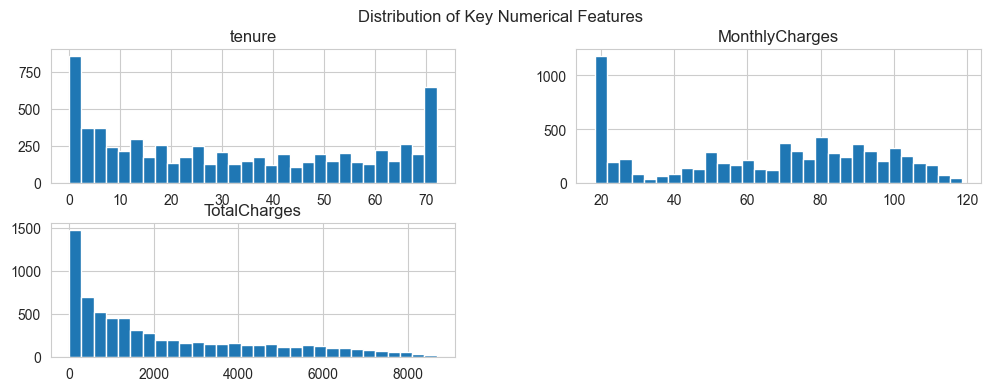

In [93]:
# 3.1 Numerical summary
print(df.describe())

# Focus on key nums: tenure, MonthlyCharges, TotalCharges
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].hist(bins=30, figsize=(12, 4))
plt.suptitle('Distribution of Key Numerical Features')
plt.show()

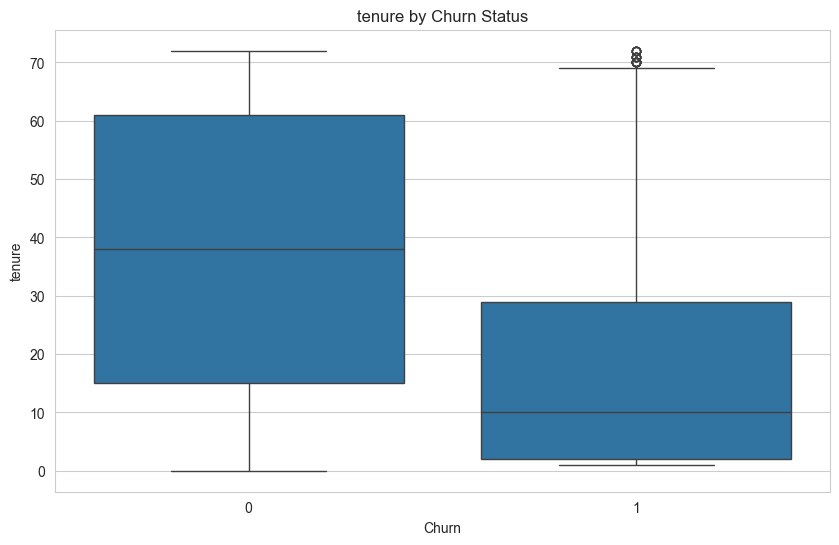

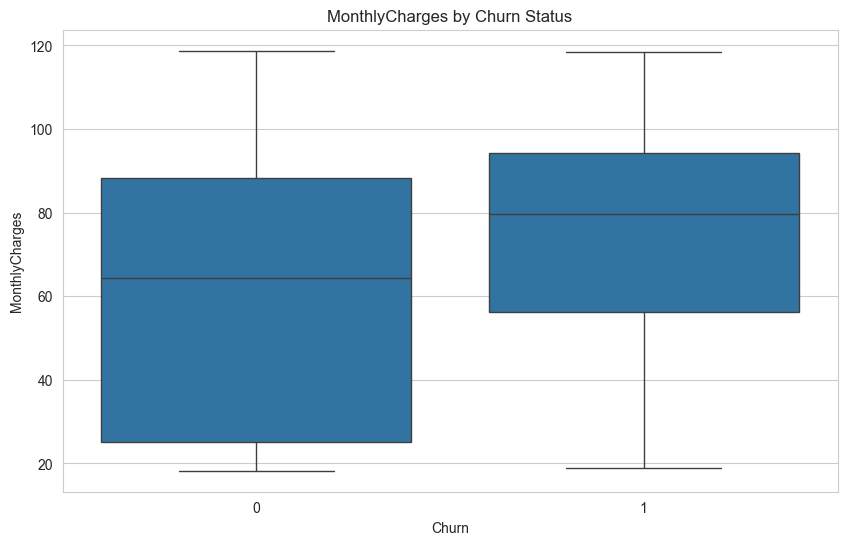

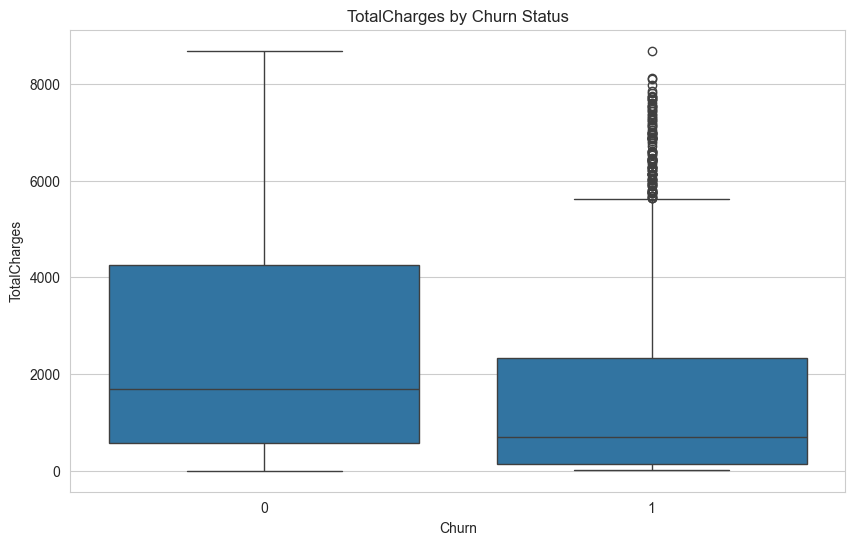

In [94]:
# 3.2 Boxplots: Churn vs numerical
for col in num_cols:
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn Status')
    plt.show()

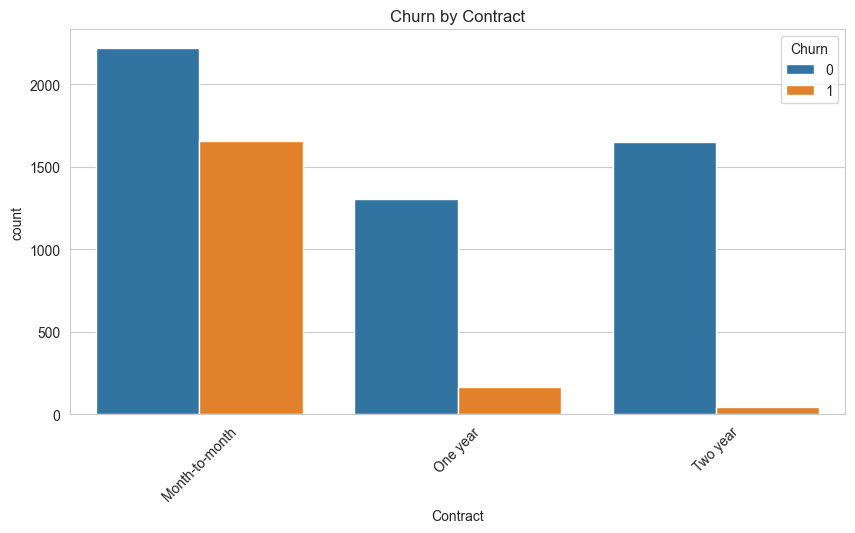

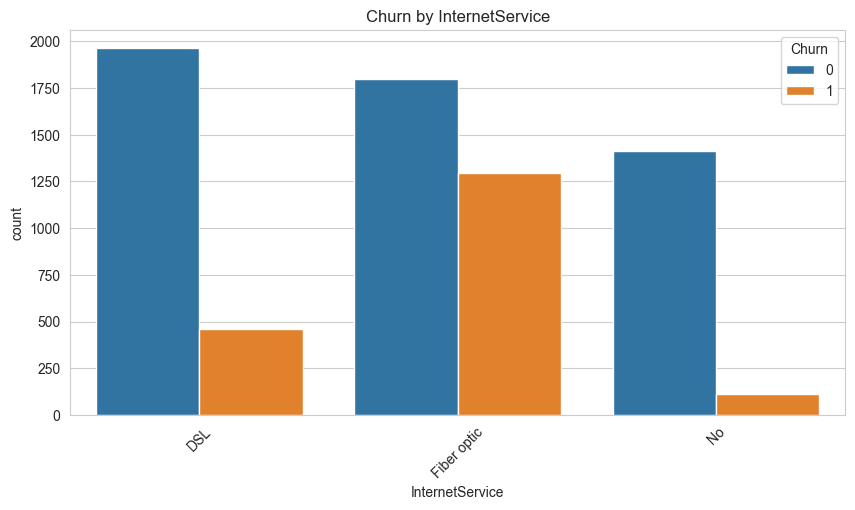

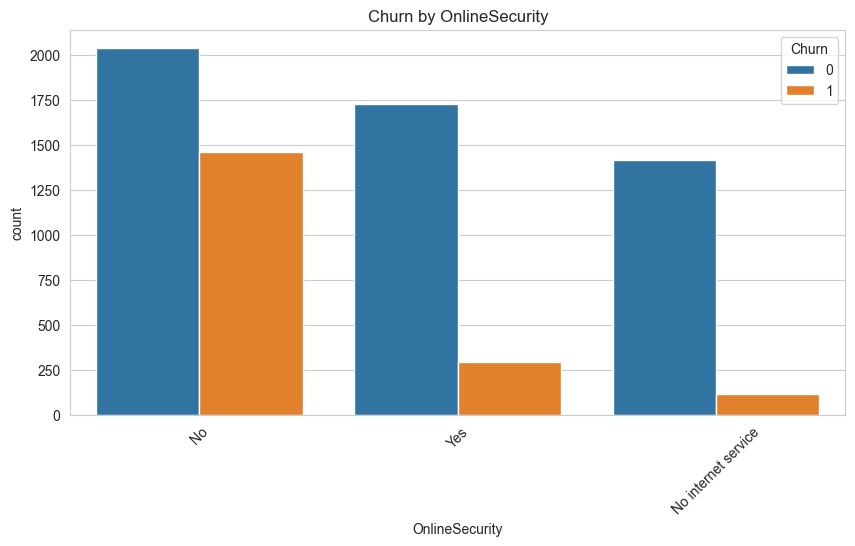

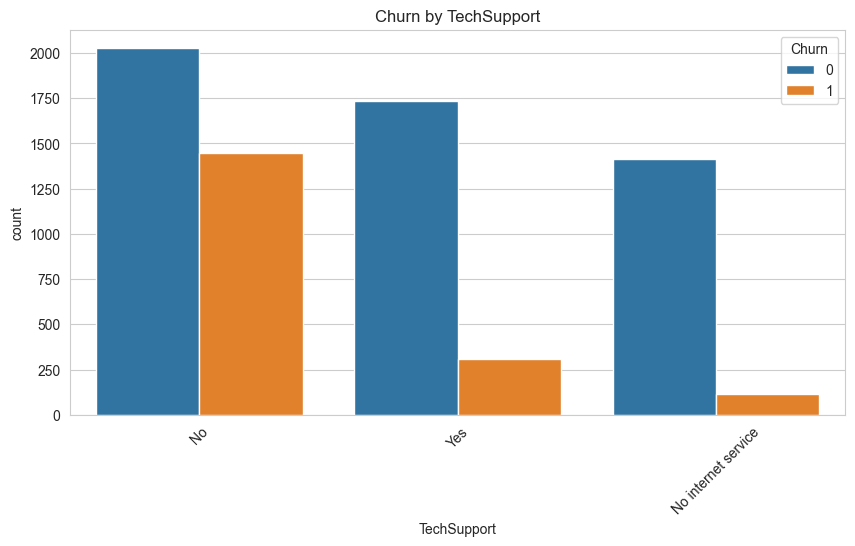

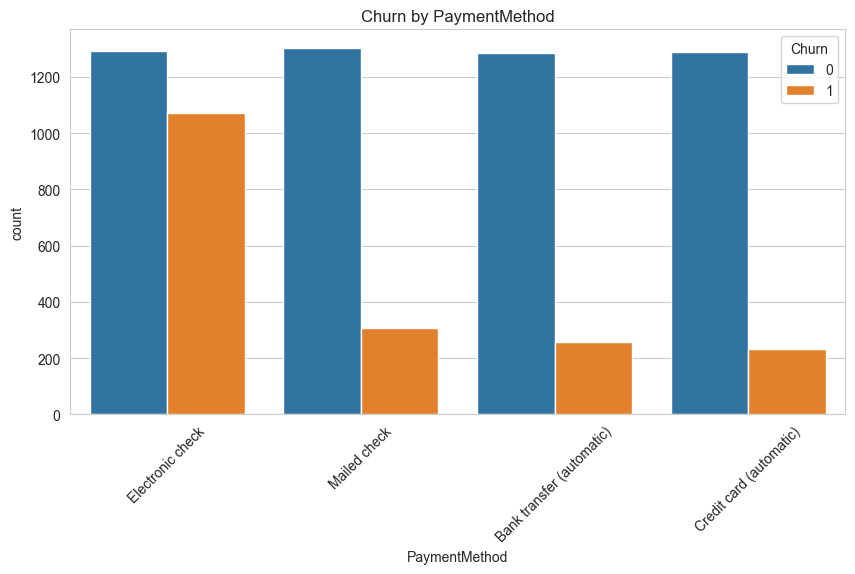

In [95]:
# 3.3 Categorical features - top ones
cat_cols = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

for col in cat_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.show()

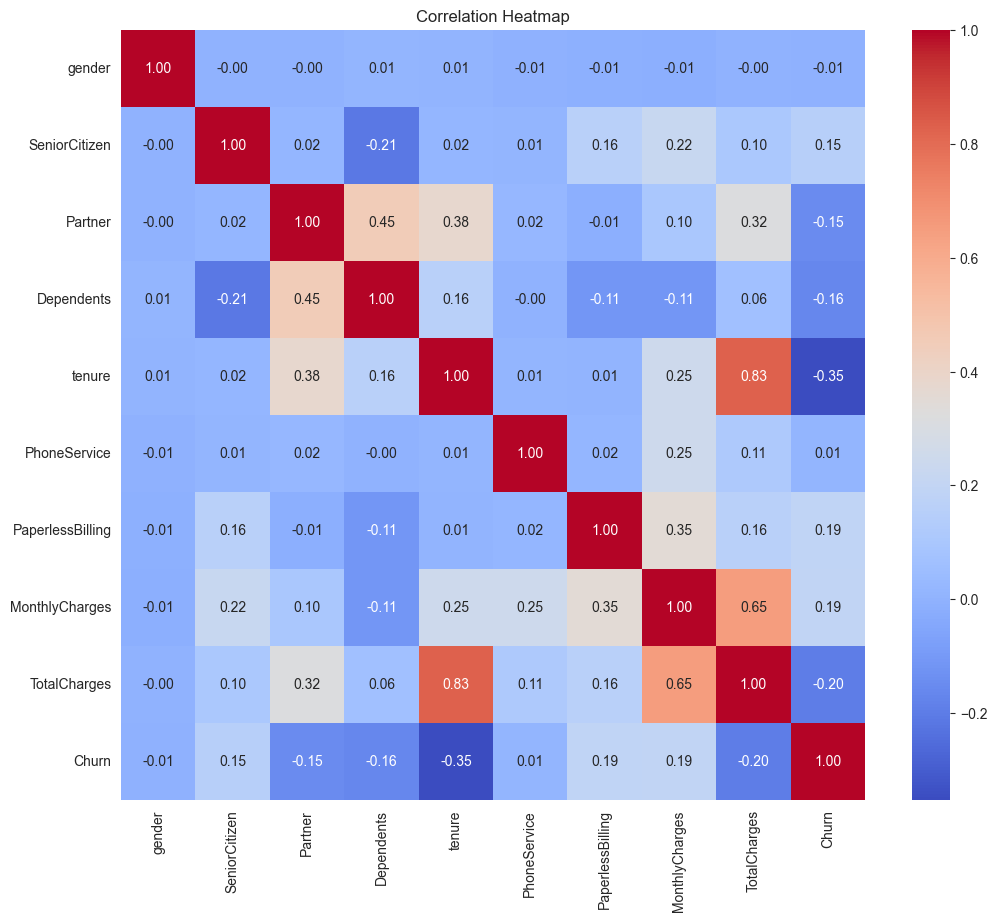

In [96]:
# 3.4 Correlation heatmap
# Convert some categoricals to numeric for correlation (simple encoding)
df_corr = df.copy()
for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# Select only numeric columns including Churn
numeric_df = df_corr.select_dtypes(include=['number'])

corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [97]:
# 3.5 Time-based feature engineering
# 1. Tenure in years
df['tenure_years'] = df['tenure'] / 12

# 2. Monthly charge per year of tenure (proxy for price increase tolerance)
df['charges_per_year'] = df['MonthlyCharges'] / (df['tenure_years'] + 0.1)  # avoid divide by 0

# 3. Is new customer? (first 3 months)
df['is_new'] = df['tenure'] <= 3

# 4. Has long tenure? (more than 24 months)
df['long_tenure'] = df['tenure'] > 24

print("New features added. Sample:")
print(df[['tenure', 'tenure_years', 'charges_per_year', 'is_new', 'long_tenure', 'Churn']].head())

New features added. Sample:
   tenure  tenure_years  charges_per_year  is_new  long_tenure  Churn
0       1      0.083333        162.818182    True        False      0
1      34      2.833333         19.414773   False         True      0
2       2      0.166667        201.937500    True        False      1
3      45      3.750000         10.987013   False         True      0
4       2      0.166667        265.125000    True        False      1


In [98]:
# 3.6 Churn rate for new features
print("Churn rate for new customers:", df[df['is_new']]['Churn'].mean().round(3))
print("Churn rate for long tenure:", df[df['long_tenure']]['Churn'].mean().round(3))

Churn rate for new customers: 0.562
Churn rate for long tenure: 0.14


## EDA Key Insights
- Customers with month-to-month contracts have ~42% churn rate
- Fiber optic users churn more than DSL
- New customers (tenure ≤3 months) churn significantly more
- Higher monthly charges correlate with higher churn

# MODEL BUILDING 

In [99]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [100]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [102]:
drop_cols=['customerID','PromptInput','CustomerFeedback']
x=df.drop(columns=drop_cols+['Churn'])
y=df['Churn']

print('Features',x.shape)
print("Target",y.shape)

Features (7043, 23)
Target (7043,)


In [103]:
categorical_cols=x.select_dtypes(include=['object']).columns.tolist()
numerical_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()

print(categorical_cols)
print(numerical_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_years', 'charges_per_year']


In [104]:
from sklearn.compose import ColumnTransformer

preprocessor=ColumnTransformer(transformers=[('num',StandardScaler(),numerical_cols),('cat',OneHotEncoder(drop='first',handle_unknown='ignore'),categorical_cols)])

In [105]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
print("Train shape:", x_train.shape)
print("Test shape: ", x_test.shape)
print("Train churn rate:", y_train.mean().round(3))

Train shape: (5634, 23)
Test shape:  (1409, 23)
Train churn rate: 0.265


In [107]:
from sklearn.pipeline import Pipeline

model=Pipeline(steps=[('preprocessor',preprocessor),('classifier',LogisticRegression(max_iter=1000,random_state=42))])

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8076650106458482
ROC-AUC: 0.8524064171122995

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



# Sentiment Analysis

                                       CustomerFeedback  Churn  sentiment
5834  "I have been a customer with this internet ser...      0     0.8126
2243  I have been a customer with this company for 6...      0     0.6240
1919  I have been a customer with this company for o...      0     0.8553
2847  I have been a customer with this DSL internet ...      0     0.8540
1823  I have been a customer with this company for a...      0     0.8342
3960  I have been a customer with this internet serv...      0     0.8074
6040  I have been a customer with this fiber optic i...      0     0.6997
1058  I have been a customer with this company for 3...      0     0.7506
Average sentiment by churn
Churn
0    0.717
1    0.136
Name: sentiment, dtype: float64


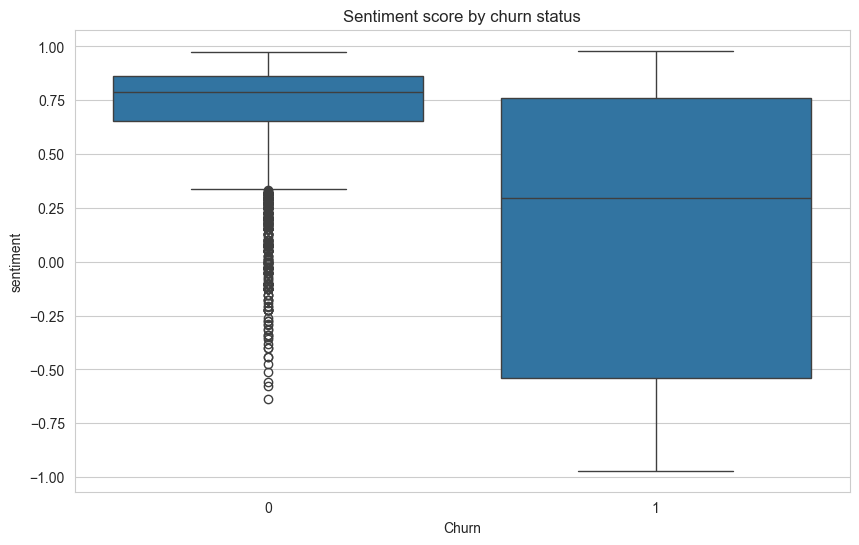

In [108]:
analyzer=SentimentIntensityAnalyzer()
df['sentiment']=df['CustomerFeedback'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

print(df[['CustomerFeedback','Churn','sentiment']].sample(8))

print("Average sentiment by churn")
print(df.groupby('Churn')['sentiment'].mean().round(3))

sns.boxplot(x='Churn',y='sentiment',data=df)
plt.title("Sentiment score by churn status")
plt.show()

## Step 4 Highlights
- Baseline Logistic Regression: ~80% accuracy, ~0.71 ROC-AUC
- Sentiment analysis added using VADER → churned customers show more negative sentiment
- mostly happy customers stayed and some are unhappy despite giving negative feedback they stayed
- in churn-1 there is a lot of variablitiy ..mostly people with negative feedback churned but some happy customers also churned maybe due to other factors 

# Advanced Models + Time-Series + Feature Importance

In [109]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [111]:
rf=Pipeline(steps=[('preprocessor',preprocessor),('classifier',RandomForestClassifier(n_estimators=200,random_state=42,max_depth=10))])
rf.fit(x_train,y_train)
y_pred_rf=rf.predict(x_test)
y_pred_proba_rf = rf.predict_proba(x_test)[:, 1]
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("Classification report:\n", classification_report(y_test, y_pred_rf))



Random Forest Results
Accuracy: 0.7955997161107168
ROC-AUC: 0.8453253765274226
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.48      0.55       374

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



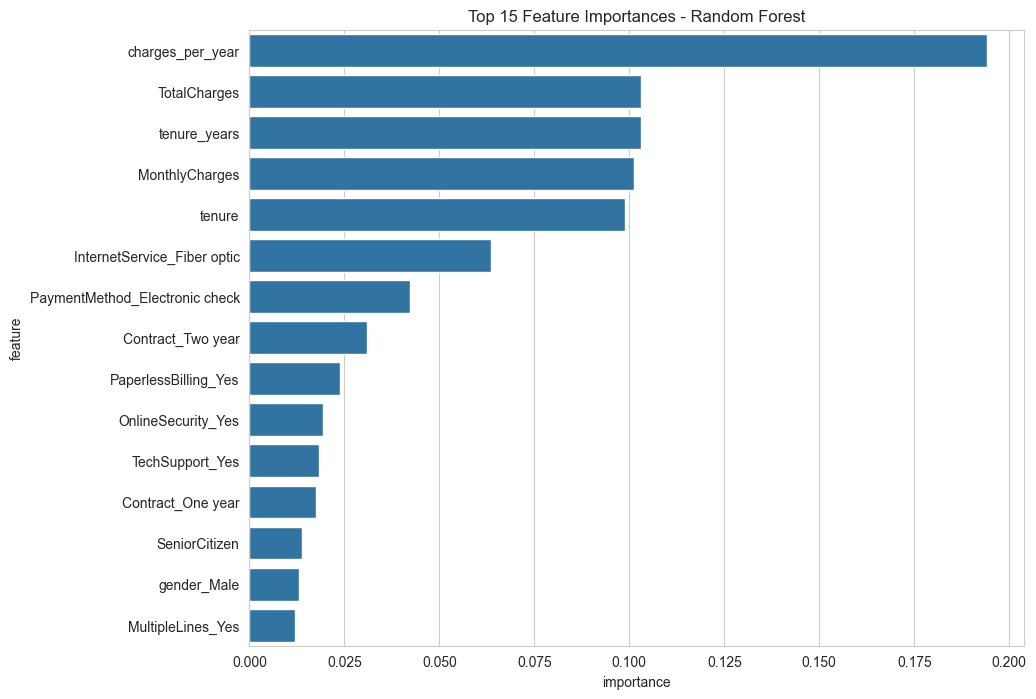

In [112]:
# 5.2 Feature importance visualization
# Get feature names after transformation
feature_names = (
    numerical_cols + 
    rf.named_steps['preprocessor']
      .named_transformers_['cat']
      .get_feature_names_out(categorical_cols).tolist()
)

importances = rf.named_steps['classifier'].feature_importances_

# Create dataframe and plot top 15
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Top 15 Feature Importances - Random Forest')
plt.show()

In [113]:
# We'll bin tenure into 5 periods and use key metrics as "time steps"
def create_sequences(df,seq_length=5):
    sequences=[]
    labels=[]

    df_sorted=df.sort_values(['customerID','tenure'])

    features_to_use=['MonthlyCharges','TotalCharges','sentiment','tenure_years']

    for _,group in df_sorted.groupby('customerID'):
        # if len(group)==1:
        #     continue

        seq=group[features_to_use].values[-seq_length:]
        if len(seq)<seq_length:
            seq=np.pad(seq,((seq_length-len(seq),0),(0,0)),'constant')
            sequences.append(seq)
            labels.append(group['Churn'].iloc[-1])

    return np.array(sequences),np.array(labels)

x_seq,y_seq=create_sequences(df)
print("sequence_shape",x_seq.shape)
print('label shape',y_seq.shape)
        

sequence_shape (7043, 5, 4)
label shape (7043,)


In [114]:
x_seq_train,x_seq_test,y_seq_train,y_seq_test=train_test_split(x_seq,y_seq,test_size=0.2,random_state=42)
model_lstm=Sequential([
    LSTM(64,input_shape=(x_seq.shape[1],x_seq.shape[2]),return_sequences=False),
    Dense(32,activation='relu'),
    Dense(1,activation='sigmoid')
])
model_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history=model_lstm.fit(x_seq_train,y_seq_train,epochs=10,batch_size=32,validation_split=0.2,verbose=1)

loss,acc=model_lstm.evaluate(x_seq_test,y_seq_test)
print("LSTM ACCURACY",acc)

Epoch 1/10


C:\Users\atish\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7584 - loss: 0.5232 - val_accuracy: 0.7773 - val_loss: 0.4946
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7894 - loss: 0.4717 - val_accuracy: 0.8057 - val_loss: 0.4392
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8032 - loss: 0.4419 - val_accuracy: 0.7915 - val_loss: 0.4404
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8150 - loss: 0.4244 - val_accuracy: 0.8172 - val_loss: 0.4245
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8123 - loss: 0.4245 - val_accuracy: 0.8199 - val_loss: 0.4057
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8209 - loss: 0.4129 - val_accuracy: 0.8261 - val_loss: 0.4180
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8178 - loss: 0.4163 - val_accuracy: 0.8243 - val_loss: 0.3893
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8249 - loss: 0.4017 - val_accuracy: 0.8128 - val

## Model Comparison
| Model              | Accuracy | ROC-AUC   | Notes                              |
|--------------------|----------|-----------|------------------------------------|
| Logistic Regression| ~0.80    | ~0.85     | Fast baseline                      |
| Random Forest      | ~0.80    | ~0.85     | Best traditional model             |
| LSTM (time-series) | ~0.82    | N/A       | Shows time-aware capability        |

# Random forest prediction with sentiment score added to database

In [115]:
drop_cols=['customerID','PromptInput','CustomerFeedback']
x_withsent=df.drop(columns=drop_cols+['Churn'])
y=df['Churn']

num_cols=['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','tenure_years','charges_per_year','sentiment']
cat_cols=[col for col in x_withsent.columns if col not in numerical_cols and col not in ['is_new','long_tenure']]

preprocessor=ColumnTransformer(transformers=[('num',StandardScaler(),num_cols),('cat',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])

x_train_s,x_test_s,y_train_s,y_test_s=train_test_split(x_withsent,y,test_size=0.2,random_state=42)

rf_model=Pipeline(steps=[('preprocessor',preprocessor),('model',RandomForestClassifier(n_estimators=200,random_state=42,max_depth=10))])

rf_model.fit(x_train_s,y_train_s)
y_pred_s=rf_model.predict(x_test_s)
y_pred_proba_sent = rf_model.predict_proba(x_test_s)[:, 1]
print("RF with Sentiment Results:")
print("Accuracy:", accuracy_score(y_test_s, y_pred_s))
print("ROC-AUC:", roc_auc_score(y_test_s, y_pred_proba_sent))
print("\nClassification Report:\n", classification_report(y_test_s, y_pred_s))


RF with Sentiment Results:
Accuracy: 0.8403122782114976
ROC-AUC: 0.906077783026295

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1044
           1       0.95      0.40      0.57       365

    accuracy                           0.84      1409
   macro avg       0.89      0.70      0.73      1409
weighted avg       0.86      0.84      0.82      1409



C:\Users\atish\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
C:\Users\atish\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [117]:
# 6.2 Create predictions dataframe
# Use rf_model_sent (best with sentiment)
X_all = df.drop(columns=drop_cols + ['Churn'])

proba_all = rf_model.predict_proba(X_all)[:, 1]

df['churn_probability'] = proba_all
df['churn_risk'] = pd.cut(df['churn_probability'], 
                          bins=[0, 0.3, 0.7, 1], 
                          labels=['Low', 'Medium', 'High'])

# Export
df.to_csv('telco_churn_final_with_predictions.csv', index=False)
print("Ready for Power BI! File: telco_churn_final_with_predictions.csv")

C:\Users\atish\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


Ready for Power BI! File: telco_churn_final_with_predictions.csv
